# Sentiment Analysis in torchtext

### Imports

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:31:06) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.22.0
Pytorch version: 0.4.0
Torch Text version: 0.2.3
Spacy version: 2.0.8


### Load data

In [2]:
data_root = pathlib.Path('./data')

In [3]:
df = pd.read_csv(data_root/'Sentiment Analysis Dataset.csv', error_bad_lines=False)
df.shape
df.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


(1578612, 4)

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


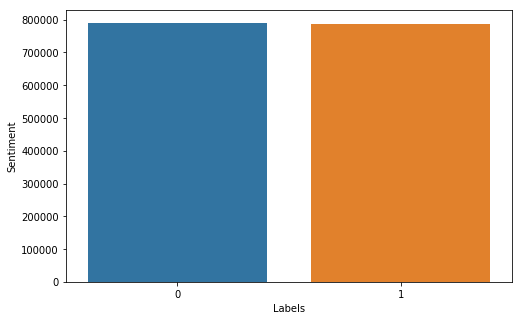

In [4]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(),y=df.Sentiment.value_counts());
ax.set(xlabel='Labels');

## Train validation split

##### torchtext have trouble handling \n. Replace \n character with space.

In [5]:
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 1578612/1578612 [00:02<00:00, 655831.85it/s]


In [6]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [7]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [8]:
traindf.shape
traindf.head()
traindf.Sentiment.value_counts()

(1262889, 4)

,ItemID,Sentiment,SentimentSource,SentimentText
0,363919,1,Sentiment140,@p3cia hihi.. already looked
1,1002689,1,Sentiment140,@lizzylou62 Good luck with the exams!
2,1257543,0,Sentiment140,The krispy kreme in CT is so closed
3,495896,1,Sentiment140,@TomJ93 because of what @_nanu_ said
4,445470,0,Sentiment140,@TellYaFriday I have nothing else to do...i'm...


1    632124
0    630765
Name: Sentiment, dtype: int64

In [9]:
valdf.shape
valdf.head()
valdf.Sentiment.value_counts()

(315723, 4)

,ItemID,Sentiment,SentimentSource,SentimentText
0,1432717,1,Sentiment140,http://www.popsugar.com/2999655 keep voting fo...
1,815480,1,Sentiment140,I follow @actionchick because she always has ...
2,1143701,1,Sentiment140,Slow This Dance Now
3,1044045,0,Sentiment140,no win on the ipod for tonight
4,979854,0,Sentiment140,@LegendaryWriter tell me about it


1    158053
0    157670
Name: Sentiment, dtype: int64

##### Save the train and validation df

In [10]:
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

## 1. Define how to process data

##### Preprocessing

In [11]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [12]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

##### Define fields

In [13]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('ItemID', None),
    ('Sentiment', label_field),
    ('SentimentSource', None),
    ('SentimentText', txt_field)
]

## 2. Create torchtext dataset

In [14]:
%%time
trainds, valds = data.TabularDataset.splits(path='./data', format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

CPU times: user 2min 55s, sys: 787 ms, total: 2min 56s
Wall time: 2min 56s


In [15]:
type(trainds)

torchtext.data.dataset.TabularDataset

In [16]:
len(trainds), len(valds)

(1262889, 315723)

In [17]:
ex = trainds[0]
type(ex)
trainds.fields.items()
ex.Sentiment
ex.SentimentText

torchtext.data.example.Example

dict_items([('ItemID', None), ('Sentiment', <torchtext.data.field.Field object at 0x7f27c645c518>), ('SentimentSource', None), ('SentimentText', <torchtext.data.field.Field object at 0x7f27c645c5f8>)])

'1'

['p3cia', 'hihi', 'already', 'looked']

In [18]:
ex = valds[0]
type(ex)
ex.Sentiment
ex.SentimentText

torchtext.data.example.Example

'1'

['http',
 'www',
 'popsugar',
 'com',
 '2999655',
 'keep',
 'voting',
 'for',
 'robert',
 'pattinson',
 'in',
 'the',
 'popsugar100',
 'as',
 'well']

## 3. Load pretrained word vectors and building vocabulary

In [19]:
%%time
vec = vocab.Vectors('glove.twitter.27B.100d.txt', './data/glove_embedding/')

CPU times: user 311 ms, sys: 464 ms, total: 775 ms
Wall time: 1.31 s


In [20]:
%%time
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

CPU times: user 9.28 s, sys: 36 ms, total: 9.32 s
Wall time: 9.32 s


In [21]:
txt_field.vocab.vectors.shape

torch.Size([100002, 100])

In [22]:
txt_field.vocab.vectors[txt_field.vocab.stoi['the']]

tensor([ 0.0952,  0.3702,  0.5429,  0.1962,  0.0482,  0.3203, -0.5964,
         0.0159, -0.1299, -0.6303,  0.0819,  0.2416, -6.0990, -0.6856,
         0.5035, -0.0341,  0.1170, -0.0077, -0.0865,  0.4362, -0.4398,
         0.2612, -0.0403, -0.1919,  0.0832, -0.5825, -0.0319,  0.1263,
         0.4012,  0.0689, -0.1052, -0.2080, -0.4255,  0.4780,  0.3465,
         0.2406,  0.0502, -0.0726, -0.0024, -0.5034, -1.0601, -0.3159,
        -0.0325, -0.0763,  0.7904,  0.0864, -0.1963,  0.0576,  0.8413,
        -0.4202, -0.0011, -0.0856,  0.0619,  0.2142, -0.1036, -0.0369,
        -0.2600, -0.3566,  0.0543,  0.0309,  0.1409, -0.0920, -0.4184,
        -0.3113, -0.1494, -0.0002, -0.3345, -0.1485, -0.1194, -0.2717,
         0.3132, -0.1100, -0.4752,  0.1406,  0.3964, -0.0494, -0.4260,
        -0.2358,  0.0615, -0.0353,  2.4161,  0.2898,  0.3888,  0.3678,
         0.2069,  0.1399, -0.4246,  0.4459,  0.2623, -0.4483,  0.0037,
        -0.2252,  0.1476, -0.3642, -0.1849,  0.2228,  0.4763, -0.5108,
      

## 4. Loading the data in batches

In [24]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [25]:
len(traindl), len(valdl)

(420963, 105241)

In [26]:
batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [27]:
batch.Sentiment

tensor([ 1,  0,  0], device='cuda:0')

##### returns word indices and lengths

In [28]:
batch.SentimentText

(tensor([[  3590,      0,     88],
         [    88,    183,    386],
         [   274,    100,      2],
         [     2,     22,     14],
         [    49,      7,     17],
         [    49,     13,   5732],
         [    49,    378,     17],
         [ 21087,     89,    427],
         [     2,      9,    846],
         [    67,     95,    816],
         [   103,   4329,   3986],
         [    17,      2,     22],
         [   299,     14,      2],
         [     7,    434,     66],
         [    18,   1286,     15],
         [    48,      2,     64],
         [   646,     29,    134],
         [   183,     15,   3264],
         [    23,    132,     35],
         [   379,      3,      2],
         [     3,   1001,     40],
         [   279,     18,    134],
         [   265,    959,   5332]], device='cuda:0'),
 tensor([ 23,  23,  23], device='cuda:0'))

In [29]:
batch.dataset.fields

{'ItemID': None,
 'Sentiment': <torchtext.data.field.Field at 0x7f27c645c518>,
 'SentimentSource': None,
 'SentimentText': <torchtext.data.field.Field at 0x7f27c645c5f8>}

In [30]:
txt_field.vocab.itos[1]

'<pad>'

##### convert index to string

Function to convert batch to text

In [31]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.SentimentText[0][:,idx].cpu().data.numpy()])

In [32]:
idxtosent(batch,0)

'therealjordin oh also i love love love papercut i really hope that makes it on your album ok just wanted to tell ya'

In [33]:
idxtosent(batch,1)

'<unk> ok then but it s funny when you re hyper i m sooo gutted i can t come to yours on wednesday'

In [34]:
idxtosent(batch,2)

'oh shit i m that douche that tweets during band sets but i don t know them nor do i like them srry'

In [35]:
batch.__dict__

{'Sentiment': tensor([ 1,  0,  0], device='cuda:0'),
 'SentimentText': (tensor([[  3590,      0,     88],
          [    88,    183,    386],
          [   274,    100,      2],
          [     2,     22,     14],
          [    49,      7,     17],
          [    49,     13,   5732],
          [    49,    378,     17],
          [ 21087,     89,    427],
          [     2,      9,    846],
          [    67,     95,    816],
          [   103,   4329,   3986],
          [    17,      2,     22],
          [   299,     14,      2],
          [     7,    434,     66],
          [    18,   1286,     15],
          [    48,      2,     64],
          [   646,     29,    134],
          [   183,     15,   3264],
          [    23,    132,     35],
          [   379,      3,      2],
          [     3,   1001,     40],
          [   279,     18,    134],
          [   265,    959,   5332]], device='cuda:0'),
  tensor([ 23,  23,  23], device='cuda:0')),
 'batch_size': 3,
 'dataset': <torchte

In [36]:
val_batch = next(iter(valdl))
val_batch.__dict__

{'Sentiment': tensor([ 0,  1,  0], device='cuda:0'),
 'SentimentText': (tensor([[     0,  67373,  82141]], device='cuda:0'),
  tensor([ 1,  1,  1], device='cuda:0')),
 'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x7f27c645c390>,
 'fields': dict_keys(['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText']),
 'train': False}

##### Note that BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. 
##### This is one of the small hiccups in torchtext. But this can be easily overcome in two ways. Either write some extra code in the training loop for getting the data out of Batch object or write a iterable wrapper around Batch Object that returns the desired data. I will take the second approach as this is much cleaner.

In [37]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [38]:
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
next(iter(train_batch_it))

((tensor([[  2948,   3499,  89132],
          [  2473,   8096,  53994],
          [   111,   5777,  13980],
          [     2,   3163,    384],
          [   707,    545,      5],
          [     0,  14366,    675],
          [    71,     44,     52],
          [  8187,     59,      3],
          [  4529,  22192,     35],
          [    39,     63,    138],
          [   141,      0,      1]], device='cuda:0'),
  tensor([ 11,  11,  10], device='cuda:0')),
 tensor([ 1,  1,  0], device='cuda:0'))

## 5. Finally Model and training

In [39]:
vocab_size = len(txt_field.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 2

#### Simple GRU model

In [40]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### Concat Pooling model

In [41]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

#### Training function

In [42]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

##### Dataloader

In [43]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), batch_sizes=(512,1024), sort_key=lambda x: len(x.SentimentText), device=0, sort_within_batch=True, repeat=False)
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
val_batch_it = BatchGenerator(valdl, 'SentimentText', 'Sentiment')

##### Train simple GRU model

In [45]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 0: train_loss: 0.4463 train_acc: 0.7892 | val_loss: 0.4154 val_acc: 0.8077


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 1: train_loss: 0.4071 train_acc: 0.8130 | val_loss: 0.4001 val_acc: 0.8178


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 2: train_loss: 0.3952 train_acc: 0.8199 | val_loss: 0.4060 val_acc: 0.8146


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 3: train_loss: 0.3877 train_acc: 0.8240 | val_loss: 0.3876 val_acc: 0.8248


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 4: train_loss: 0.3822 train_acc: 0.8270 | val_loss: 0.3861 val_acc: 0.8256



##### Train Concat Pooling model

In [46]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 0: train_loss: 0.4349 train_acc: 0.7959 | val_loss: 0.4036 val_acc: 0.8153


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 1: train_loss: 0.3975 train_acc: 0.8189 | val_loss: 0.3913 val_acc: 0.8227


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 2: train_loss: 0.3853 train_acc: 0.8257 | val_loss: 0.3877 val_acc: 0.8250


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 3: train_loss: 0.3777 train_acc: 0.8300 | val_loss: 0.3822 val_acc: 0.8283


HBox(children=(IntProgress(value=0, max=2467), HTML(value='')))

HBox(children=(IntProgress(value=0, max=309), HTML(value='')))

Epoch 4: train_loss: 0.3715 train_acc: 0.8332 | val_loss: 0.3804 val_acc: 0.8289

